In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
# !unzip spb_10.zip

# !gdown 12hpNMvLEmPfO9wy1qDPEe-L1ORyWX0H9
# !unzip /content/spb_img.zip
# !gdown 1D9p4Kj2kWtyedRBd9OPGeC6J6YVGr-XK
# !unzip /content/spb_img_2.zip
# !gdown 1C6cV8TSIsSD--VvHLSUgU1wlkRFKEw9K # 1sc7BOJauQGD3I9mfPCHPu_9gL8XWn2Xp
# !unzip /content/drive/MyDrive/ZIPS/spb_all_new_2.zip
# !mkdir spb_all_new_3
# !mv spb_all_new_2 spb_all_new_3
# !rename all_img all_img_2

!gdown 1C6cV8TSIsSD--VvHLSUgU1wlkRFKEw9K
!unzip /content/spb_all_new_2.zip
!mkdir img_300_2
!mv spb_all_new img_300_2

In [ ]:
# !unzip /content/img_300.zip
# !mkdir img_300_2
# !mv img_300 img_300_2

In [ ]:
# DATA_DIR = './spb_10/'
DATA_DIR = '/content/img_300_2'

In [ ]:
image_size = 256 #64
batch_size = 32 #128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

Подготовим наши изображения к дальнейшему использованию

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
    ]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
# next(iter(train_dl))

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64): #64
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64): #64
    for images, _ in dl:
        show_images(images, nmax)
        break

Посмотрим, как выглядит батч

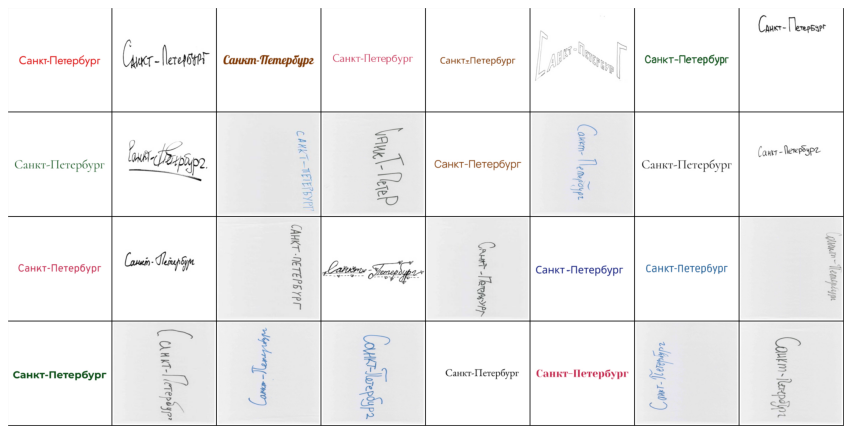

In [ ]:
show_batch(train_dl)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

Давайте перейдем непосредственно к построению GANа. Напомним, что GAN состоит из двух сетей: *генератора*, задача которого – научиться генерировать изображения, похожие на обучающую выборку, из случайного шума, и *дискриминатора*, который учится распознавать, настоящее это изображение или сгенерированное генератором.

Построим генератор и дискриминатор на свертках:

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=16, stride=8, padding=4, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=16, stride=8, padding=4, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Посмотрим, как выглядит шум, из которого будут генерироваться изображения

torch.Size([32, 3, 256, 256])


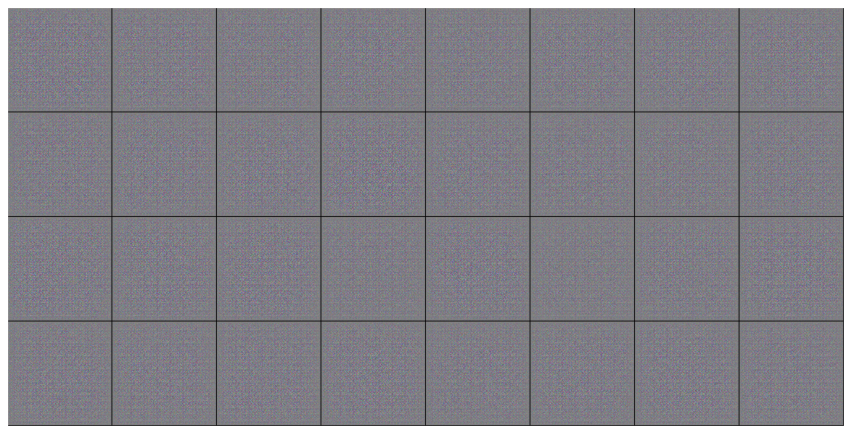

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 500 # 1000

In [ ]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [1/500], loss_g: 7.9877, loss_d: 0.1690, real_score: 0.9507, fake_score: 0.0858


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [2/500], loss_g: 11.6617, loss_d: 0.1105, real_score: 0.9841, fake_score: 0.0578


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [3/500], loss_g: 6.2214, loss_d: 0.1422, real_score: 0.9735, fake_score: 0.0594


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [4/500], loss_g: 6.4281, loss_d: 0.4448, real_score: 0.9050, fake_score: 0.1237


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [5/500], loss_g: 5.6588, loss_d: 0.4015, real_score: 0.8923, fake_score: 0.1154


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [6/500], loss_g: 7.0976, loss_d: 0.4496, real_score: 0.8582, fake_score: 0.1228


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [7/500], loss_g: 5.9363, loss_d: 0.4880, real_score: 0.8519, fake_score: 0.1417


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [8/500], loss_g: 5.3794, loss_d: 0.5458, real_score: 0.8338, fake_score: 0.1597


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [9/500], loss_g: 4.8118, loss_d: 0.3670, real_score: 0.8594, fake_score: 0.1355


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [10/500], loss_g: 4.8729, loss_d: 0.5220, real_score: 0.8464, fake_score: 0.1376


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [11/500], loss_g: 5.5271, loss_d: 0.5681, real_score: 0.8336, fake_score: 0.1384


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [12/500], loss_g: 4.8871, loss_d: 0.4175, real_score: 0.8605, fake_score: 0.1369


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [13/500], loss_g: 4.6568, loss_d: 0.3739, real_score: 0.8780, fake_score: 0.1315


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [14/500], loss_g: 4.9124, loss_d: 0.3691, real_score: 0.8812, fake_score: 0.1163


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [15/500], loss_g: 5.1457, loss_d: 0.2505, real_score: 0.9015, fake_score: 0.1050


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [16/500], loss_g: 4.5224, loss_d: 0.3678, real_score: 0.8712, fake_score: 0.1181


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [17/500], loss_g: 5.7498, loss_d: 0.3363, real_score: 0.8817, fake_score: 0.1237


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [18/500], loss_g: 5.3383, loss_d: 0.5100, real_score: 0.8513, fake_score: 0.1425


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [19/500], loss_g: 5.5222, loss_d: 0.3505, real_score: 0.8859, fake_score: 0.1344


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [20/500], loss_g: 4.8271, loss_d: 0.2302, real_score: 0.8953, fake_score: 0.0825


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [21/500], loss_g: 4.4964, loss_d: 0.8556, real_score: 0.8320, fake_score: 0.1559


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [22/500], loss_g: 4.7796, loss_d: 0.4406, real_score: 0.8638, fake_score: 0.1529


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [23/500], loss_g: 5.1914, loss_d: 0.3635, real_score: 0.8858, fake_score: 0.1229


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [24/500], loss_g: 4.6069, loss_d: 0.3973, real_score: 0.8673, fake_score: 0.1277


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [25/500], loss_g: 5.2658, loss_d: 0.3955, real_score: 0.8685, fake_score: 0.1312


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [26/500], loss_g: 5.2653, loss_d: 0.3259, real_score: 0.8773, fake_score: 0.1107


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [27/500], loss_g: 4.4608, loss_d: 0.5824, real_score: 0.8509, fake_score: 0.1516


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [28/500], loss_g: 4.6422, loss_d: 0.2367, real_score: 0.9126, fake_score: 0.1085


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [29/500], loss_g: 4.6189, loss_d: 0.4871, real_score: 0.8472, fake_score: 0.1308


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [30/500], loss_g: 5.1122, loss_d: 0.6988, real_score: 0.8109, fake_score: 0.1894


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [31/500], loss_g: 4.5211, loss_d: 0.3693, real_score: 0.8872, fake_score: 0.1292


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [32/500], loss_g: 4.7459, loss_d: 0.2229, real_score: 0.9177, fake_score: 0.0949


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [33/500], loss_g: 5.2193, loss_d: 0.3142, real_score: 0.8785, fake_score: 0.1116


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [34/500], loss_g: 5.3974, loss_d: 0.4684, real_score: 0.8889, fake_score: 0.1156


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [35/500], loss_g: 4.3346, loss_d: 0.3159, real_score: 0.8751, fake_score: 0.1180


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [36/500], loss_g: 4.6977, loss_d: 0.6458, real_score: 0.8241, fake_score: 0.1896


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [37/500], loss_g: 4.3272, loss_d: 0.4152, real_score: 0.8826, fake_score: 0.0948


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [38/500], loss_g: 4.4043, loss_d: 0.6374, real_score: 0.8325, fake_score: 0.1908


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [39/500], loss_g: 5.1864, loss_d: 0.4534, real_score: 0.8637, fake_score: 0.1490


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [40/500], loss_g: 4.2146, loss_d: 0.2486, real_score: 0.9005, fake_score: 0.0973


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [41/500], loss_g: 4.4839, loss_d: 0.2019, real_score: 0.9197, fake_score: 0.0877


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [42/500], loss_g: 4.5652, loss_d: 0.4204, real_score: 0.8641, fake_score: 0.1243


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [43/500], loss_g: 4.9870, loss_d: 0.2722, real_score: 0.8954, fake_score: 0.1119


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [44/500], loss_g: 5.0380, loss_d: 0.2003, real_score: 0.9215, fake_score: 0.0836


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [45/500], loss_g: 5.0417, loss_d: 0.3424, real_score: 0.8881, fake_score: 0.0890


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [46/500], loss_g: 4.8405, loss_d: 0.3616, real_score: 0.8995, fake_score: 0.1293


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [47/500], loss_g: 4.7037, loss_d: 0.4482, real_score: 0.8663, fake_score: 0.1331


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [48/500], loss_g: 4.9340, loss_d: 0.5660, real_score: 0.8427, fake_score: 0.1470


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [49/500], loss_g: 5.0296, loss_d: 0.2159, real_score: 0.9202, fake_score: 0.0969


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [50/500], loss_g: 4.9467, loss_d: 0.1943, real_score: 0.9202, fake_score: 0.0764


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [51/500], loss_g: 4.9889, loss_d: 0.3155, real_score: 0.8971, fake_score: 0.0956


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [52/500], loss_g: 4.9818, loss_d: 0.2387, real_score: 0.9155, fake_score: 0.0931


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [53/500], loss_g: 4.8232, loss_d: 0.4373, real_score: 0.8836, fake_score: 0.0896


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [54/500], loss_g: 5.2846, loss_d: 0.3676, real_score: 0.9025, fake_score: 0.1269


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [55/500], loss_g: 5.6991, loss_d: 0.2767, real_score: 0.9096, fake_score: 0.1011


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [56/500], loss_g: 5.7002, loss_d: 0.3814, real_score: 0.8834, fake_score: 0.1111


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [57/500], loss_g: 4.6078, loss_d: 0.1967, real_score: 0.9263, fake_score: 0.0806


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [58/500], loss_g: 4.3104, loss_d: 0.1325, real_score: 0.9368, fake_score: 0.0559


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [59/500], loss_g: 4.8601, loss_d: 0.7427, real_score: 0.8151, fake_score: 0.1626


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [60/500], loss_g: 4.6931, loss_d: 0.6723, real_score: 0.8376, fake_score: 0.1862


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [61/500], loss_g: 4.2232, loss_d: 0.3663, real_score: 0.8660, fake_score: 0.1103


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [62/500], loss_g: 5.2562, loss_d: 0.3999, real_score: 0.8761, fake_score: 0.1193


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [63/500], loss_g: 4.8329, loss_d: 0.5971, real_score: 0.8761, fake_score: 0.1409


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [64/500], loss_g: 4.5987, loss_d: 0.4065, real_score: 0.8670, fake_score: 0.1238


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [65/500], loss_g: 4.6954, loss_d: 0.3248, real_score: 0.9038, fake_score: 0.1210


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [66/500], loss_g: 4.4129, loss_d: 0.1768, real_score: 0.9265, fake_score: 0.0759


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [67/500], loss_g: 5.1407, loss_d: 0.2363, real_score: 0.9174, fake_score: 0.0860


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [68/500], loss_g: 5.3703, loss_d: 0.3326, real_score: 0.8908, fake_score: 0.1223


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [69/500], loss_g: 4.5729, loss_d: 0.2885, real_score: 0.8988, fake_score: 0.0778


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [70/500], loss_g: 5.0028, loss_d: 0.4596, real_score: 0.8946, fake_score: 0.1237


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [71/500], loss_g: 4.4196, loss_d: 0.3266, real_score: 0.8975, fake_score: 0.1010


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [72/500], loss_g: 4.6288, loss_d: 0.2373, real_score: 0.9127, fake_score: 0.0852


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [73/500], loss_g: 4.5852, loss_d: 0.1615, real_score: 0.9383, fake_score: 0.0624


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [74/500], loss_g: 4.9222, loss_d: 0.3340, real_score: 0.8918, fake_score: 0.1060


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [75/500], loss_g: 4.5987, loss_d: 0.3976, real_score: 0.8876, fake_score: 0.0923


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [76/500], loss_g: 5.0666, loss_d: 0.5303, real_score: 0.8582, fake_score: 0.1726


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [77/500], loss_g: 4.3182, loss_d: 0.1779, real_score: 0.9235, fake_score: 0.0723


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [78/500], loss_g: 4.7271, loss_d: 0.2645, real_score: 0.9001, fake_score: 0.0851


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [79/500], loss_g: 5.8843, loss_d: 0.4846, real_score: 0.8691, fake_score: 0.1259


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [80/500], loss_g: 4.6245, loss_d: 0.5593, real_score: 0.8526, fake_score: 0.1466


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [81/500], loss_g: 4.3187, loss_d: 0.3143, real_score: 0.9055, fake_score: 0.1009


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [82/500], loss_g: 4.3548, loss_d: 0.4674, real_score: 0.8909, fake_score: 0.0941


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [83/500], loss_g: 4.3916, loss_d: 0.4176, real_score: 0.8836, fake_score: 0.1381


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [84/500], loss_g: 4.1671, loss_d: 0.1642, real_score: 0.9337, fake_score: 0.0704


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [85/500], loss_g: 4.5419, loss_d: 0.3668, real_score: 0.8770, fake_score: 0.1009


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [86/500], loss_g: 4.1822, loss_d: 0.1955, real_score: 0.9285, fake_score: 0.0873


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [87/500], loss_g: 5.6488, loss_d: 0.3407, real_score: 0.9056, fake_score: 0.0888


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [88/500], loss_g: 5.5939, loss_d: 0.2700, real_score: 0.9013, fake_score: 0.0968


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [89/500], loss_g: 4.7037, loss_d: 0.1425, real_score: 0.9447, fake_score: 0.0652


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [90/500], loss_g: 4.8635, loss_d: 0.1269, real_score: 0.9389, fake_score: 0.0477


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [91/500], loss_g: 4.6274, loss_d: 0.2642, real_score: 0.9133, fake_score: 0.1016


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [92/500], loss_g: 4.9883, loss_d: 0.2119, real_score: 0.9117, fake_score: 0.0672


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [93/500], loss_g: 5.1527, loss_d: 0.2888, real_score: 0.9101, fake_score: 0.1042


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [94/500], loss_g: 5.7724, loss_d: 0.2543, real_score: 0.9239, fake_score: 0.0849


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [95/500], loss_g: 5.3419, loss_d: 0.1811, real_score: 0.9325, fake_score: 0.0690


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [96/500], loss_g: 5.0512, loss_d: 0.1570, real_score: 0.9347, fake_score: 0.0630


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [97/500], loss_g: 5.3095, loss_d: 0.2249, real_score: 0.9250, fake_score: 0.0755


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [98/500], loss_g: 4.6957, loss_d: 0.1553, real_score: 0.9315, fake_score: 0.0548


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [99/500], loss_g: 5.6219, loss_d: 0.6097, real_score: 0.8324, fake_score: 0.1567


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [100/500], loss_g: 4.7010, loss_d: 0.2805, real_score: 0.9023, fake_score: 0.1129


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [101/500], loss_g: 4.6416, loss_d: 0.4350, real_score: 0.8750, fake_score: 0.0895


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [102/500], loss_g: 4.4478, loss_d: 0.6681, real_score: 0.8172, fake_score: 0.1825


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [103/500], loss_g: 4.7754, loss_d: 0.3308, real_score: 0.9201, fake_score: 0.0782


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [104/500], loss_g: 5.8829, loss_d: 0.1932, real_score: 0.9782, fake_score: 0.0681


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [105/500], loss_g: 6.0141, loss_d: 0.1408, real_score: 0.9615, fake_score: 0.0234


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [106/500], loss_g: 6.3188, loss_d: 0.2148, real_score: 0.9535, fake_score: 0.0321


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [107/500], loss_g: 6.5073, loss_d: 0.2507, real_score: 0.9611, fake_score: 0.0724


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [108/500], loss_g: 5.6721, loss_d: 0.0214, real_score: 0.9927, fake_score: 0.0132


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [109/500], loss_g: 5.5890, loss_d: 0.6049, real_score: 0.9530, fake_score: 0.0184


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [110/500], loss_g: 5.4891, loss_d: 0.0621, real_score: 0.9884, fake_score: 0.0427


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [111/500], loss_g: 5.4931, loss_d: 0.0242, real_score: 0.9906, fake_score: 0.0115


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [112/500], loss_g: 5.3526, loss_d: 0.0118, real_score: 0.9958, fake_score: 0.0075


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [113/500], loss_g: 9.2676, loss_d: 0.0710, real_score: 0.9748, fake_score: 0.0260


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [114/500], loss_g: 5.8440, loss_d: 0.1149, real_score: 0.9541, fake_score: 0.0472


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [115/500], loss_g: 5.6425, loss_d: 0.2389, real_score: 0.9219, fake_score: 0.0530


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [116/500], loss_g: 5.9878, loss_d: 0.3865, real_score: 0.9154, fake_score: 0.0890


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [117/500], loss_g: 5.7965, loss_d: 0.3024, real_score: 0.9045, fake_score: 0.0767


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [118/500], loss_g: 4.9449, loss_d: 0.1799, real_score: 0.9320, fake_score: 0.0775


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [119/500], loss_g: 5.4457, loss_d: 0.1103, real_score: 0.9598, fake_score: 0.0539


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [120/500], loss_g: 5.7536, loss_d: 0.1365, real_score: 0.9496, fake_score: 0.0588


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [121/500], loss_g: 5.4361, loss_d: 0.1056, real_score: 0.9455, fake_score: 0.0331


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [122/500], loss_g: 6.2016, loss_d: 0.2190, real_score: 0.9215, fake_score: 0.0710


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [123/500], loss_g: 5.1652, loss_d: 0.5556, real_score: 0.8738, fake_score: 0.1245


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [124/500], loss_g: 4.5912, loss_d: 0.2768, real_score: 0.9278, fake_score: 0.0589


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [125/500], loss_g: 5.4385, loss_d: 0.3578, real_score: 0.9072, fake_score: 0.1040


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [126/500], loss_g: 6.9313, loss_d: 0.3731, real_score: 0.8810, fake_score: 0.1026


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [127/500], loss_g: 5.0458, loss_d: 0.1598, real_score: 0.9559, fake_score: 0.0747


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [128/500], loss_g: 4.7704, loss_d: 0.3506, real_score: 0.9260, fake_score: 0.0510


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [129/500], loss_g: 4.4814, loss_d: 0.2145, real_score: 0.9229, fake_score: 0.0940


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [130/500], loss_g: 4.3840, loss_d: 0.2326, real_score: 0.9068, fake_score: 0.0692


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [131/500], loss_g: 6.0770, loss_d: 0.4039, real_score: 0.8983, fake_score: 0.1055


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [132/500], loss_g: 4.9586, loss_d: 0.1992, real_score: 0.9311, fake_score: 0.0822


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [133/500], loss_g: 6.2281, loss_d: 0.2660, real_score: 0.9090, fake_score: 0.0850


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [134/500], loss_g: 4.6694, loss_d: 0.3153, real_score: 0.9080, fake_score: 0.0757


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [135/500], loss_g: 5.1883, loss_d: 0.2777, real_score: 0.9258, fake_score: 0.1024


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [136/500], loss_g: 4.7851, loss_d: 0.1829, real_score: 0.9339, fake_score: 0.0666


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [137/500], loss_g: 5.0933, loss_d: 0.2345, real_score: 0.9188, fake_score: 0.0838


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [138/500], loss_g: 4.7017, loss_d: 0.2296, real_score: 0.9353, fake_score: 0.0386


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [139/500], loss_g: 5.5032, loss_d: 0.4872, real_score: 0.8888, fake_score: 0.1194


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [140/500], loss_g: 4.8418, loss_d: 0.1375, real_score: 0.9489, fake_score: 0.0613


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [141/500], loss_g: 5.4640, loss_d: 0.1496, real_score: 0.9502, fake_score: 0.0648


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [142/500], loss_g: 4.1505, loss_d: 0.0968, real_score: 0.9585, fake_score: 0.0457


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [143/500], loss_g: 4.3143, loss_d: 0.1217, real_score: 0.9487, fake_score: 0.0540


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [144/500], loss_g: 5.8106, loss_d: 0.2507, real_score: 0.9080, fake_score: 0.0595


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [145/500], loss_g: 5.1833, loss_d: 0.3683, real_score: 0.8986, fake_score: 0.1219


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [146/500], loss_g: 4.7973, loss_d: 0.2725, real_score: 0.9235, fake_score: 0.0799


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [147/500], loss_g: 4.8796, loss_d: 0.1558, real_score: 0.9374, fake_score: 0.0583


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [148/500], loss_g: 4.9611, loss_d: 0.2555, real_score: 0.9078, fake_score: 0.0781


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [149/500], loss_g: 5.0655, loss_d: 0.1653, real_score: 0.9397, fake_score: 0.0702


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [150/500], loss_g: 5.0109, loss_d: 0.3077, real_score: 0.9247, fake_score: 0.0587


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [151/500], loss_g: 4.8334, loss_d: 0.1636, real_score: 0.9484, fake_score: 0.0780


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [152/500], loss_g: 4.9531, loss_d: 0.3241, real_score: 0.9610, fake_score: 0.0187


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [153/500], loss_g: 5.5380, loss_d: 0.1117, real_score: 0.9684, fake_score: 0.0542


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [154/500], loss_g: 5.4857, loss_d: 0.0171, real_score: 0.9962, fake_score: 0.0128


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [155/500], loss_g: 5.8651, loss_d: 0.0540, real_score: 0.9795, fake_score: 0.0069


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [156/500], loss_g: 6.8616, loss_d: 0.1155, real_score: 0.9777, fake_score: 0.0456


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [157/500], loss_g: 7.0260, loss_d: 0.2112, real_score: 0.9403, fake_score: 0.0552


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [158/500], loss_g: 5.6643, loss_d: 0.5567, real_score: 0.9098, fake_score: 0.0595


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [159/500], loss_g: 5.4398, loss_d: 0.1568, real_score: 0.9458, fake_score: 0.0655


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [160/500], loss_g: 4.7995, loss_d: 0.1264, real_score: 0.9533, fake_score: 0.0528


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [161/500], loss_g: 4.6257, loss_d: 0.1622, real_score: 0.9312, fake_score: 0.0523


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [162/500], loss_g: 4.5996, loss_d: 0.1817, real_score: 0.9352, fake_score: 0.0722


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [163/500], loss_g: 5.7103, loss_d: 0.2240, real_score: 0.9274, fake_score: 0.0736


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [164/500], loss_g: 4.7128, loss_d: 0.2427, real_score: 0.9075, fake_score: 0.0714


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [165/500], loss_g: 5.6907, loss_d: 0.3657, real_score: 0.9120, fake_score: 0.1043


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [166/500], loss_g: 5.7050, loss_d: 0.1265, real_score: 0.9497, fake_score: 0.0532


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [167/500], loss_g: 5.2193, loss_d: 0.1269, real_score: 0.9435, fake_score: 0.0468


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [168/500], loss_g: 5.3841, loss_d: 0.3252, real_score: 0.8923, fake_score: 0.0889


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [169/500], loss_g: 6.2817, loss_d: 0.2453, real_score: 0.9307, fake_score: 0.0935


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [170/500], loss_g: 5.2078, loss_d: 0.2822, real_score: 0.9103, fake_score: 0.0731


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [171/500], loss_g: 5.6593, loss_d: 0.2936, real_score: 0.9239, fake_score: 0.0898


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [172/500], loss_g: 4.8263, loss_d: 0.1218, real_score: 0.9499, fake_score: 0.0549


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [173/500], loss_g: 4.9475, loss_d: 0.2385, real_score: 0.9223, fake_score: 0.0467


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [174/500], loss_g: 4.5896, loss_d: 0.1202, real_score: 0.9627, fake_score: 0.0579


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [175/500], loss_g: 6.1349, loss_d: 0.1857, real_score: 0.9450, fake_score: 0.0640


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [176/500], loss_g: 6.2434, loss_d: 0.1173, real_score: 0.9525, fake_score: 0.0493


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [177/500], loss_g: 5.1919, loss_d: 0.2536, real_score: 0.9249, fake_score: 0.0638


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [178/500], loss_g: 5.7878, loss_d: 0.2712, real_score: 0.9253, fake_score: 0.0533


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [179/500], loss_g: 4.6123, loss_d: 0.3076, real_score: 0.9008, fake_score: 0.0905


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [180/500], loss_g: 5.4105, loss_d: 0.3677, real_score: 0.9126, fake_score: 0.1135


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [181/500], loss_g: 5.1750, loss_d: 0.1514, real_score: 0.9430, fake_score: 0.0589


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [182/500], loss_g: 4.7108, loss_d: 0.4225, real_score: 0.9036, fake_score: 0.0771


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [183/500], loss_g: 4.6886, loss_d: 0.3859, real_score: 0.8840, fake_score: 0.1232


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [184/500], loss_g: 4.8325, loss_d: 0.1768, real_score: 0.9345, fake_score: 0.0705


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [185/500], loss_g: 5.7262, loss_d: 0.2218, real_score: 0.9319, fake_score: 0.0686


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [186/500], loss_g: 4.7711, loss_d: 0.1069, real_score: 0.9538, fake_score: 0.0477


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [187/500], loss_g: 5.8774, loss_d: 0.2746, real_score: 0.9167, fake_score: 0.0645


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [188/500], loss_g: 4.7866, loss_d: 0.1313, real_score: 0.9528, fake_score: 0.0595


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [189/500], loss_g: 5.9774, loss_d: 0.0439, real_score: 0.9860, fake_score: 0.0248


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [190/500], loss_g: 6.9316, loss_d: 0.0700, real_score: 0.9789, fake_score: 0.0336


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [191/500], loss_g: 7.2900, loss_d: 0.4037, real_score: 0.9454, fake_score: 0.0202


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [192/500], loss_g: 6.7428, loss_d: 0.1908, real_score: 0.9594, fake_score: 0.0487


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [193/500], loss_g: 9.2888, loss_d: 0.1037, real_score: 0.9784, fake_score: 0.0438


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [194/500], loss_g: 6.4433, loss_d: 0.0367, real_score: 0.9865, fake_score: 0.0188


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [195/500], loss_g: 5.1826, loss_d: 0.1207, real_score: 0.9595, fake_score: 0.0162


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [196/500], loss_g: 6.7924, loss_d: 0.4303, real_score: 0.9389, fake_score: 0.0947


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [197/500], loss_g: 5.8327, loss_d: 0.1025, real_score: 0.9623, fake_score: 0.0444


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [198/500], loss_g: 5.9112, loss_d: 0.0824, real_score: 0.9670, fake_score: 0.0345


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [199/500], loss_g: 6.2495, loss_d: 0.0551, real_score: 0.9774, fake_score: 0.0246


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [200/500], loss_g: 6.8797, loss_d: 0.4222, real_score: 0.9235, fake_score: 0.0598


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [201/500], loss_g: 5.1095, loss_d: 0.2293, real_score: 0.9336, fake_score: 0.0485


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [202/500], loss_g: 7.4335, loss_d: 0.2489, real_score: 0.9350, fake_score: 0.0889


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [203/500], loss_g: 6.0238, loss_d: 0.0683, real_score: 0.9745, fake_score: 0.0321


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [204/500], loss_g: 5.5961, loss_d: 0.0847, real_score: 0.9669, fake_score: 0.0335


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [205/500], loss_g: 4.8098, loss_d: 0.1528, real_score: 0.9563, fake_score: 0.0178


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [206/500], loss_g: 5.5998, loss_d: 0.2103, real_score: 0.9372, fake_score: 0.0789


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [207/500], loss_g: 5.4591, loss_d: 0.0814, real_score: 0.9671, fake_score: 0.0362


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [208/500], loss_g: 6.3084, loss_d: 0.2132, real_score: 0.9483, fake_score: 0.0556


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [209/500], loss_g: 4.9819, loss_d: 0.1078, real_score: 0.9533, fake_score: 0.0306


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [210/500], loss_g: 6.9316, loss_d: 0.5935, real_score: 0.8947, fake_score: 0.0875


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [211/500], loss_g: 6.6316, loss_d: 0.2466, real_score: 0.9392, fake_score: 0.0747


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [212/500], loss_g: 6.0381, loss_d: 0.1309, real_score: 0.9635, fake_score: 0.0477


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [213/500], loss_g: 5.3205, loss_d: 0.2170, real_score: 0.9214, fake_score: 0.0453


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [214/500], loss_g: 7.0959, loss_d: 0.3047, real_score: 0.9344, fake_score: 0.0941


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [215/500], loss_g: 5.6990, loss_d: 0.2229, real_score: 0.9390, fake_score: 0.0461


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [216/500], loss_g: 5.6636, loss_d: 0.1696, real_score: 0.9432, fake_score: 0.0640


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [217/500], loss_g: 5.3761, loss_d: 0.2245, real_score: 0.9269, fake_score: 0.0494


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [218/500], loss_g: 7.0046, loss_d: 0.3356, real_score: 0.9300, fake_score: 0.1005


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [219/500], loss_g: 4.8975, loss_d: 0.0889, real_score: 0.9633, fake_score: 0.0410


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [220/500], loss_g: 5.6049, loss_d: 0.2397, real_score: 0.9400, fake_score: 0.0327


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [221/500], loss_g: 5.1817, loss_d: 0.6300, real_score: 0.8786, fake_score: 0.1079


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [222/500], loss_g: 4.4429, loss_d: 0.2726, real_score: 0.9459, fake_score: 0.0497


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [223/500], loss_g: 5.4249, loss_d: 0.2282, real_score: 0.9352, fake_score: 0.0874


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [224/500], loss_g: 4.5633, loss_d: 0.0902, real_score: 0.9647, fake_score: 0.0406


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [225/500], loss_g: 5.7794, loss_d: 0.1547, real_score: 0.9518, fake_score: 0.0512


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [226/500], loss_g: 5.3236, loss_d: 0.2082, real_score: 0.9222, fake_score: 0.0513


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [227/500], loss_g: 6.0433, loss_d: 0.3573, real_score: 0.9176, fake_score: 0.0786


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [228/500], loss_g: 6.4541, loss_d: 0.4379, real_score: 0.9105, fake_score: 0.0798


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [229/500], loss_g: 5.4838, loss_d: 0.1411, real_score: 0.9627, fake_score: 0.0652


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [230/500], loss_g: 4.9642, loss_d: 0.3076, real_score: 0.9373, fake_score: 0.0434


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [231/500], loss_g: 6.0001, loss_d: 0.1435, real_score: 0.9530, fake_score: 0.0676


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [232/500], loss_g: 5.5175, loss_d: 0.1345, real_score: 0.9532, fake_score: 0.0497


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [233/500], loss_g: 5.0732, loss_d: 0.1141, real_score: 0.9537, fake_score: 0.0443


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [234/500], loss_g: 5.3255, loss_d: 0.2136, real_score: 0.9444, fake_score: 0.0313


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [235/500], loss_g: 6.0013, loss_d: 0.2251, real_score: 0.9322, fake_score: 0.0696


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [236/500], loss_g: 5.0931, loss_d: 0.2244, real_score: 0.9479, fake_score: 0.0380


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [237/500], loss_g: 6.4656, loss_d: 0.3182, real_score: 0.9102, fake_score: 0.1146


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [238/500], loss_g: 5.4568, loss_d: 0.1415, real_score: 0.9451, fake_score: 0.0509


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [239/500], loss_g: 4.9491, loss_d: 0.1832, real_score: 0.9336, fake_score: 0.0519


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [240/500], loss_g: 5.0200, loss_d: 0.1823, real_score: 0.9457, fake_score: 0.0695


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [241/500], loss_g: 5.4174, loss_d: 0.1803, real_score: 0.9388, fake_score: 0.0616


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [242/500], loss_g: 4.9453, loss_d: 0.0930, real_score: 0.9584, fake_score: 0.0357


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [243/500], loss_g: 4.3852, loss_d: 0.2321, real_score: 0.9411, fake_score: 0.0426


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [244/500], loss_g: 4.9363, loss_d: 0.1422, real_score: 0.9560, fake_score: 0.0671


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [245/500], loss_g: 5.4749, loss_d: 0.0610, real_score: 0.9719, fake_score: 0.0271


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [246/500], loss_g: 5.7303, loss_d: 0.0664, real_score: 0.9706, fake_score: 0.0290


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [247/500], loss_g: 6.4250, loss_d: 0.1313, real_score: 0.9524, fake_score: 0.0418


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [248/500], loss_g: 6.5438, loss_d: 0.0949, real_score: 0.9646, fake_score: 0.0381


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [249/500], loss_g: 6.5744, loss_d: 0.0984, real_score: 0.9629, fake_score: 0.0357


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [250/500], loss_g: 5.6755, loss_d: 0.0658, real_score: 0.9735, fake_score: 0.0287


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [251/500], loss_g: 5.6101, loss_d: 0.1887, real_score: 0.9323, fake_score: 0.0465


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [252/500], loss_g: 6.8180, loss_d: 0.1930, real_score: 0.9499, fake_score: 0.0674


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [253/500], loss_g: 5.5742, loss_d: 0.1804, real_score: 0.9406, fake_score: 0.0271


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [254/500], loss_g: 7.3163, loss_d: 0.2094, real_score: 0.9490, fake_score: 0.0767


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [255/500], loss_g: 6.0820, loss_d: 0.1626, real_score: 0.9356, fake_score: 0.0465


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [256/500], loss_g: 9.3496, loss_d: 0.2773, real_score: 0.9201, fake_score: 0.0836


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [257/500], loss_g: 9.1884, loss_d: 0.1122, real_score: 0.9798, fake_score: 0.0389


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [258/500], loss_g: 8.7200, loss_d: 0.2247, real_score: 0.9361, fake_score: 0.0410


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [259/500], loss_g: 5.9463, loss_d: 0.2277, real_score: 0.9234, fake_score: 0.0623


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [260/500], loss_g: 7.0726, loss_d: 0.1772, real_score: 0.9561, fake_score: 0.0646


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [261/500], loss_g: 5.3529, loss_d: 0.0434, real_score: 0.9818, fake_score: 0.0180


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [262/500], loss_g: 6.0228, loss_d: 0.1024, real_score: 0.9620, fake_score: 0.0405


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [263/500], loss_g: 5.8699, loss_d: 0.2806, real_score: 0.9218, fake_score: 0.0443


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [264/500], loss_g: 5.2714, loss_d: 0.1541, real_score: 0.9554, fake_score: 0.0697


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [265/500], loss_g: 5.4980, loss_d: 0.2934, real_score: 0.9196, fake_score: 0.0468


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [266/500], loss_g: 8.1971, loss_d: 0.6188, real_score: 0.9282, fake_score: 0.0647


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [267/500], loss_g: 6.2047, loss_d: 0.1108, real_score: 0.9708, fake_score: 0.0497


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [268/500], loss_g: 6.2676, loss_d: 0.2677, real_score: 0.9101, fake_score: 0.0984


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [269/500], loss_g: 5.3081, loss_d: 0.1748, real_score: 0.9350, fake_score: 0.0713


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [270/500], loss_g: 4.5271, loss_d: 0.1670, real_score: 0.9352, fake_score: 0.0566


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [271/500], loss_g: 5.2627, loss_d: 0.2673, real_score: 0.9349, fake_score: 0.0494


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [272/500], loss_g: 5.5017, loss_d: 0.3726, real_score: 0.9114, fake_score: 0.0950


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [273/500], loss_g: 5.4046, loss_d: 0.2351, real_score: 0.9412, fake_score: 0.0584


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [274/500], loss_g: 6.9541, loss_d: 0.2887, real_score: 0.9295, fake_score: 0.0696


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [275/500], loss_g: 5.1595, loss_d: 0.1116, real_score: 0.9643, fake_score: 0.0512


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [276/500], loss_g: 5.1244, loss_d: 0.1214, real_score: 0.9593, fake_score: 0.0303


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [277/500], loss_g: 6.2558, loss_d: 0.1598, real_score: 0.9532, fake_score: 0.0660


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [278/500], loss_g: 4.9305, loss_d: 0.2413, real_score: 0.9437, fake_score: 0.0277


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [279/500], loss_g: 6.2975, loss_d: 0.3392, real_score: 0.9227, fake_score: 0.0758


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [280/500], loss_g: 7.4099, loss_d: 0.2024, real_score: 0.9670, fake_score: 0.0560


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [281/500], loss_g: 6.4398, loss_d: 0.0622, real_score: 0.9800, fake_score: 0.0281


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [282/500], loss_g: 5.9014, loss_d: 0.2220, real_score: 0.9192, fake_score: 0.0619


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [283/500], loss_g: 5.3366, loss_d: 0.1860, real_score: 0.9387, fake_score: 0.0697


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [284/500], loss_g: 5.5458, loss_d: 0.3666, real_score: 0.9175, fake_score: 0.0519


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [285/500], loss_g: 4.7172, loss_d: 0.1292, real_score: 0.9582, fake_score: 0.0639


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [286/500], loss_g: 4.3083, loss_d: 0.1316, real_score: 0.9493, fake_score: 0.0567


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [287/500], loss_g: 4.6762, loss_d: 0.0850, real_score: 0.9642, fake_score: 0.0361


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [288/500], loss_g: 4.3172, loss_d: 0.2377, real_score: 0.9209, fake_score: 0.0547


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [289/500], loss_g: 5.4017, loss_d: 0.2272, real_score: 0.9291, fake_score: 0.0982


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [290/500], loss_g: 5.4576, loss_d: 0.1861, real_score: 0.9360, fake_score: 0.0600


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [291/500], loss_g: 4.8593, loss_d: 0.0920, real_score: 0.9611, fake_score: 0.0428


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [292/500], loss_g: 5.2020, loss_d: 0.0702, real_score: 0.9671, fake_score: 0.0291


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [293/500], loss_g: 5.8147, loss_d: 0.1126, real_score: 0.9585, fake_score: 0.0452


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [294/500], loss_g: 5.9923, loss_d: 0.0425, real_score: 0.9823, fake_score: 0.0210


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [295/500], loss_g: 5.5188, loss_d: 0.1297, real_score: 0.9562, fake_score: 0.0320


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [296/500], loss_g: 5.5521, loss_d: 0.0950, real_score: 0.9594, fake_score: 0.0322


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [297/500], loss_g: 6.0873, loss_d: 0.1334, real_score: 0.9557, fake_score: 0.0381


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [298/500], loss_g: 5.8192, loss_d: 0.0906, real_score: 0.9731, fake_score: 0.0367


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [299/500], loss_g: 5.7849, loss_d: 0.1425, real_score: 0.9525, fake_score: 0.0267


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [300/500], loss_g: 7.1316, loss_d: 0.1404, real_score: 0.9643, fake_score: 0.0589


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [301/500], loss_g: 7.3073, loss_d: 0.2702, real_score: 0.9338, fake_score: 0.0381


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [302/500], loss_g: 5.2351, loss_d: 0.0862, real_score: 0.9732, fake_score: 0.0429


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [303/500], loss_g: 5.0648, loss_d: 0.2846, real_score: 0.9391, fake_score: 0.0283


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [304/500], loss_g: 6.3920, loss_d: 0.1805, real_score: 0.9569, fake_score: 0.0770


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [305/500], loss_g: 4.9348, loss_d: 0.0928, real_score: 0.9646, fake_score: 0.0379


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [306/500], loss_g: 5.3984, loss_d: 0.1427, real_score: 0.9467, fake_score: 0.0549


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [307/500], loss_g: 5.0315, loss_d: 0.1280, real_score: 0.9402, fake_score: 0.0329


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [308/500], loss_g: 7.4636, loss_d: 0.5640, real_score: 0.8978, fake_score: 0.0913


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [309/500], loss_g: 5.7773, loss_d: 0.1808, real_score: 0.9566, fake_score: 0.0690


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [310/500], loss_g: 5.1547, loss_d: 0.0491, real_score: 0.9828, fake_score: 0.0275


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [311/500], loss_g: 6.3150, loss_d: 0.2899, real_score: 0.9233, fake_score: 0.0609


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [312/500], loss_g: 6.1189, loss_d: 0.2287, real_score: 0.9332, fake_score: 0.0704


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [313/500], loss_g: 5.5002, loss_d: 0.2783, real_score: 0.9299, fake_score: 0.0630


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [314/500], loss_g: 6.2387, loss_d: 0.2325, real_score: 0.9242, fake_score: 0.0836


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [315/500], loss_g: 6.2036, loss_d: 0.1702, real_score: 0.9543, fake_score: 0.0555


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [316/500], loss_g: 5.7311, loss_d: 0.0728, real_score: 0.9731, fake_score: 0.0346


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [317/500], loss_g: 5.3783, loss_d: 0.2329, real_score: 0.9335, fake_score: 0.0384


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [318/500], loss_g: 5.1144, loss_d: 0.2722, real_score: 0.9074, fake_score: 0.0884


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [319/500], loss_g: 6.0352, loss_d: 0.3984, real_score: 0.9167, fake_score: 0.0733


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [320/500], loss_g: 5.6657, loss_d: 0.2762, real_score: 0.9229, fake_score: 0.0739


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [321/500], loss_g: 6.1721, loss_d: 0.1113, real_score: 0.9660, fake_score: 0.0532


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [322/500], loss_g: 5.6270, loss_d: 0.2368, real_score: 0.9433, fake_score: 0.0286


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [323/500], loss_g: 7.7764, loss_d: 0.3103, real_score: 0.9311, fake_score: 0.0770


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [324/500], loss_g: 5.8527, loss_d: 0.0350, real_score: 0.9927, fake_score: 0.0253


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [325/500], loss_g: 5.6512, loss_d: 0.1458, real_score: 0.9434, fake_score: 0.0641


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [326/500], loss_g: 5.4086, loss_d: 0.1828, real_score: 0.9371, fake_score: 0.0621


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [327/500], loss_g: 4.7094, loss_d: 0.1339, real_score: 0.9454, fake_score: 0.0382


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [328/500], loss_g: 5.1550, loss_d: 0.1239, real_score: 0.9531, fake_score: 0.0547


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [329/500], loss_g: 5.8159, loss_d: 0.3761, real_score: 0.9342, fake_score: 0.0459


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [330/500], loss_g: 6.6174, loss_d: 0.3509, real_score: 0.9076, fake_score: 0.0899


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [331/500], loss_g: 5.4617, loss_d: 0.2370, real_score: 0.9443, fake_score: 0.0826


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [332/500], loss_g: 5.4155, loss_d: 0.1621, real_score: 0.9396, fake_score: 0.0540


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [333/500], loss_g: 5.1352, loss_d: 0.2310, real_score: 0.9317, fake_score: 0.0434


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [334/500], loss_g: 5.1232, loss_d: 0.2534, real_score: 0.9302, fake_score: 0.0819


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [335/500], loss_g: 4.9648, loss_d: 0.1412, real_score: 0.9498, fake_score: 0.0605


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [336/500], loss_g: 5.2676, loss_d: 0.1626, real_score: 0.9456, fake_score: 0.0527


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [337/500], loss_g: 4.7219, loss_d: 0.0730, real_score: 0.9681, fake_score: 0.0336


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [338/500], loss_g: 6.0953, loss_d: 0.1148, real_score: 0.9602, fake_score: 0.0466


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [339/500], loss_g: 5.2016, loss_d: 0.0613, real_score: 0.9717, fake_score: 0.0267


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [340/500], loss_g: 5.1028, loss_d: 0.1216, real_score: 0.9501, fake_score: 0.0272


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [341/500], loss_g: 6.0693, loss_d: 0.3261, real_score: 0.9114, fake_score: 0.0701


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [342/500], loss_g: 5.9457, loss_d: 0.1529, real_score: 0.9535, fake_score: 0.0673


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [343/500], loss_g: 5.6207, loss_d: 0.3285, real_score: 0.9330, fake_score: 0.0344


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [344/500], loss_g: 6.0958, loss_d: 0.1082, real_score: 0.9774, fake_score: 0.0537


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [345/500], loss_g: 5.9127, loss_d: 0.0327, real_score: 0.9826, fake_score: 0.0118


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [346/500], loss_g: 7.4792, loss_d: 0.0793, real_score: 0.9787, fake_score: 0.0373


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [347/500], loss_g: 7.8302, loss_d: 0.4380, real_score: 0.9297, fake_score: 0.0525


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [348/500], loss_g: 5.7361, loss_d: 0.1347, real_score: 0.9549, fake_score: 0.0528


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [349/500], loss_g: 5.2455, loss_d: 0.0538, real_score: 0.9807, fake_score: 0.0284


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [350/500], loss_g: 6.2154, loss_d: 0.0682, real_score: 0.9712, fake_score: 0.0286


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [351/500], loss_g: 5.8020, loss_d: 0.0365, real_score: 0.9857, fake_score: 0.0177


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [352/500], loss_g: 5.3947, loss_d: 0.0250, real_score: 0.9879, fake_score: 0.0113


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [353/500], loss_g: 5.3485, loss_d: 0.0444, real_score: 0.9786, fake_score: 0.0177


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [354/500], loss_g: 6.9964, loss_d: 0.0666, real_score: 0.9739, fake_score: 0.0269


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [355/500], loss_g: 6.1520, loss_d: 0.0545, real_score: 0.9775, fake_score: 0.0261


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [356/500], loss_g: 6.7996, loss_d: 0.1001, real_score: 0.9548, fake_score: 0.0294


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [357/500], loss_g: 7.4297, loss_d: 0.3066, real_score: 0.9203, fake_score: 0.0717


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [358/500], loss_g: 7.3349, loss_d: 0.1910, real_score: 0.9522, fake_score: 0.0606


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [359/500], loss_g: 5.3028, loss_d: 0.0493, real_score: 0.9806, fake_score: 0.0183


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [360/500], loss_g: 5.9714, loss_d: 0.0393, real_score: 0.9853, fake_score: 0.0224


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [361/500], loss_g: 6.7961, loss_d: 0.0623, real_score: 0.9747, fake_score: 0.0226


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [362/500], loss_g: 6.6573, loss_d: 0.4743, real_score: 0.9133, fake_score: 0.0512


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [363/500], loss_g: 6.5934, loss_d: 0.2848, real_score: 0.9261, fake_score: 0.0989


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [364/500], loss_g: 5.5771, loss_d: 0.0843, real_score: 0.9678, fake_score: 0.0387


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [365/500], loss_g: 4.8693, loss_d: 0.1166, real_score: 0.9486, fake_score: 0.0387


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [366/500], loss_g: 5.8952, loss_d: 0.2723, real_score: 0.9411, fake_score: 0.0568


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [367/500], loss_g: 5.7892, loss_d: 0.3312, real_score: 0.9358, fake_score: 0.0436


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [368/500], loss_g: 6.0477, loss_d: 0.0813, real_score: 0.9817, fake_score: 0.0436


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [369/500], loss_g: 6.3235, loss_d: 0.1335, real_score: 0.9558, fake_score: 0.0144


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [370/500], loss_g: 6.7035, loss_d: 0.1489, real_score: 0.9587, fake_score: 0.0344


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [371/500], loss_g: 9.0326, loss_d: 0.3984, real_score: 0.9366, fake_score: 0.0868


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [372/500], loss_g: 5.6158, loss_d: 0.1663, real_score: 0.9765, fake_score: 0.0253


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [373/500], loss_g: 8.5031, loss_d: 0.0558, real_score: 0.9834, fake_score: 0.0262


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [374/500], loss_g: 6.7503, loss_d: 0.4415, real_score: 0.9296, fake_score: 0.0467


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [375/500], loss_g: 6.0809, loss_d: 0.1920, real_score: 0.9324, fake_score: 0.0697


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [376/500], loss_g: 6.9347, loss_d: 0.5361, real_score: 0.9405, fake_score: 0.0486


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [377/500], loss_g: 9.0811, loss_d: 0.2395, real_score: 0.9445, fake_score: 0.0569


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [378/500], loss_g: 5.2809, loss_d: 0.0374, real_score: 0.9952, fake_score: 0.0274


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [379/500], loss_g: 5.0967, loss_d: 0.5029, real_score: 0.9538, fake_score: 0.0146


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [380/500], loss_g: 5.9255, loss_d: 0.6811, real_score: 0.9593, fake_score: 0.0396


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [381/500], loss_g: 7.9765, loss_d: 0.0475, real_score: 0.9939, fake_score: 0.0275


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [382/500], loss_g: 5.3865, loss_d: 0.0718, real_score: 0.9717, fake_score: 0.0081


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [383/500], loss_g: 6.1517, loss_d: 0.1672, real_score: 0.9610, fake_score: 0.0605


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [384/500], loss_g: 7.8916, loss_d: 0.2235, real_score: 0.9477, fake_score: 0.0834


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [385/500], loss_g: 6.0707, loss_d: 0.4751, real_score: 0.9060, fake_score: 0.0458


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [386/500], loss_g: 4.9029, loss_d: 0.1051, real_score: 0.9575, fake_score: 0.0464


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [387/500], loss_g: 6.0339, loss_d: 0.3076, real_score: 0.9403, fake_score: 0.0423


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [388/500], loss_g: 6.0752, loss_d: 0.3984, real_score: 0.9103, fake_score: 0.1042


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [389/500], loss_g: 5.7450, loss_d: 0.0386, real_score: 0.9879, fake_score: 0.0241


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [390/500], loss_g: 4.7057, loss_d: 0.1891, real_score: 0.9452, fake_score: 0.0342


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [391/500], loss_g: 6.1210, loss_d: 0.1981, real_score: 0.9333, fake_score: 0.0645


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [392/500], loss_g: 6.3218, loss_d: 0.1650, real_score: 0.9555, fake_score: 0.0546


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [393/500], loss_g: 6.3355, loss_d: 0.0668, real_score: 0.9774, fake_score: 0.0321


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [394/500], loss_g: 5.6192, loss_d: 0.0301, real_score: 0.9900, fake_score: 0.0186


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [395/500], loss_g: 5.2193, loss_d: 0.3732, real_score: 0.9325, fake_score: 0.0337


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [396/500], loss_g: 5.8807, loss_d: 0.3411, real_score: 0.9423, fake_score: 0.0914


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [397/500], loss_g: 5.9764, loss_d: 0.0646, real_score: 0.9715, fake_score: 0.0270


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [398/500], loss_g: 4.8354, loss_d: 0.3172, real_score: 0.9547, fake_score: 0.0178


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [399/500], loss_g: 5.6155, loss_d: 0.1234, real_score: 0.9698, fake_score: 0.0588


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [400/500], loss_g: 5.2609, loss_d: 0.0629, real_score: 0.9710, fake_score: 0.0270


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [401/500], loss_g: 5.1877, loss_d: 0.0795, real_score: 0.9581, fake_score: 0.0268


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [402/500], loss_g: 5.0289, loss_d: 0.2716, real_score: 0.9280, fake_score: 0.0557


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [403/500], loss_g: 5.0581, loss_d: 0.3350, real_score: 0.9054, fake_score: 0.0906


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [404/500], loss_g: 5.7386, loss_d: 0.6546, real_score: 0.9124, fake_score: 0.0879


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [405/500], loss_g: 4.5614, loss_d: 0.1211, real_score: 0.9601, fake_score: 0.0656


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [406/500], loss_g: 5.5598, loss_d: 0.0702, real_score: 0.9649, fake_score: 0.0266


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [407/500], loss_g: 4.9109, loss_d: 0.2261, real_score: 0.9379, fake_score: 0.0431


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [408/500], loss_g: 5.1407, loss_d: 0.2056, real_score: 0.9353, fake_score: 0.0923


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [409/500], loss_g: 5.3826, loss_d: 0.1593, real_score: 0.9425, fake_score: 0.0569


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [410/500], loss_g: 4.8063, loss_d: 0.2587, real_score: 0.9212, fake_score: 0.0488


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [411/500], loss_g: 5.4368, loss_d: 0.5107, real_score: 0.9192, fake_score: 0.0852


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [412/500], loss_g: 3.9681, loss_d: 0.1232, real_score: 0.9482, fake_score: 0.0455


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [413/500], loss_g: 5.7639, loss_d: 0.3684, real_score: 0.9314, fake_score: 0.0723


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [414/500], loss_g: 5.5657, loss_d: 0.2480, real_score: 0.9251, fake_score: 0.0720


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [415/500], loss_g: 5.0480, loss_d: 0.3478, real_score: 0.9342, fake_score: 0.0706


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [416/500], loss_g: 5.4458, loss_d: 0.5726, real_score: 0.9518, fake_score: 0.0456


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [417/500], loss_g: 6.2339, loss_d: 0.1231, real_score: 0.9876, fake_score: 0.0493


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [418/500], loss_g: 4.5638, loss_d: 0.4487, real_score: 0.9402, fake_score: 0.0266


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [419/500], loss_g: 6.3649, loss_d: 0.0630, real_score: 0.9881, fake_score: 0.0390


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [420/500], loss_g: 5.3984, loss_d: 0.0570, real_score: 0.9695, fake_score: 0.0088


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [421/500], loss_g: 5.7208, loss_d: 0.0141, real_score: 0.9995, fake_score: 0.0128


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [422/500], loss_g: 5.6947, loss_d: 0.2443, real_score: 0.9687, fake_score: 0.0499


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [423/500], loss_g: 5.8898, loss_d: 0.2371, real_score: 0.9447, fake_score: 0.0220


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [424/500], loss_g: 5.7173, loss_d: 0.1594, real_score: 0.9478, fake_score: 0.0609


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [425/500], loss_g: 4.8850, loss_d: 0.3608, real_score: 0.9461, fake_score: 0.0426


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [426/500], loss_g: 5.5321, loss_d: 0.2056, real_score: 0.9450, fake_score: 0.0573


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [427/500], loss_g: 6.1606, loss_d: 0.1729, real_score: 0.9499, fake_score: 0.0466


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [428/500], loss_g: 5.5872, loss_d: 0.1204, real_score: 0.9572, fake_score: 0.0550


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [429/500], loss_g: 6.4668, loss_d: 0.1700, real_score: 0.9565, fake_score: 0.0554


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [430/500], loss_g: 5.3514, loss_d: 0.4359, real_score: 0.9455, fake_score: 0.0247


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [431/500], loss_g: 4.9778, loss_d: 0.0950, real_score: 0.9687, fake_score: 0.0492


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [432/500], loss_g: 5.0898, loss_d: 0.2189, real_score: 0.9570, fake_score: 0.0219


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [433/500], loss_g: 6.6979, loss_d: 0.1993, real_score: 0.9423, fake_score: 0.0644


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [434/500], loss_g: 6.5957, loss_d: 0.1471, real_score: 0.9553, fake_score: 0.0508


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [435/500], loss_g: 5.0939, loss_d: 0.2078, real_score: 0.9577, fake_score: 0.0259


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [436/500], loss_g: 6.6200, loss_d: 0.1122, real_score: 0.9714, fake_score: 0.0568


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [437/500], loss_g: 6.2437, loss_d: 0.1265, real_score: 0.9581, fake_score: 0.0200


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [438/500], loss_g: 5.9665, loss_d: 0.0839, real_score: 0.9751, fake_score: 0.0425


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [439/500], loss_g: 6.3311, loss_d: 0.2665, real_score: 0.9308, fake_score: 0.0457


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [440/500], loss_g: 6.2944, loss_d: 0.1037, real_score: 0.9668, fake_score: 0.0412


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [441/500], loss_g: 5.0754, loss_d: 0.3854, real_score: 0.9609, fake_score: 0.0219


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [442/500], loss_g: 6.4153, loss_d: 0.6036, real_score: 0.9397, fake_score: 0.0613


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [443/500], loss_g: 6.6204, loss_d: 0.4002, real_score: 0.9496, fake_score: 0.0474


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [444/500], loss_g: 7.8216, loss_d: 0.4418, real_score: 0.9623, fake_score: 0.0378


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [445/500], loss_g: 5.0770, loss_d: 0.1618, real_score: 0.9608, fake_score: 0.0378


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [446/500], loss_g: 5.3135, loss_d: 0.0309, real_score: 0.9980, fake_score: 0.0244


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [447/500], loss_g: 4.7952, loss_d: 0.0356, real_score: 0.9926, fake_score: 0.0266


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [448/500], loss_g: 4.7491, loss_d: 0.5183, real_score: 0.9514, fake_score: 0.0213


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [449/500], loss_g: 5.1972, loss_d: 0.3344, real_score: 0.9472, fake_score: 0.0448


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [450/500], loss_g: 5.2858, loss_d: 0.1116, real_score: 0.9740, fake_score: 0.0653


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [451/500], loss_g: 5.2098, loss_d: 0.1796, real_score: 0.9638, fake_score: 0.0106


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [452/500], loss_g: 5.6160, loss_d: 0.0163, real_score: 0.9981, fake_score: 0.0134


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [453/500], loss_g: 5.6100, loss_d: 0.1865, real_score: 0.9670, fake_score: 0.0114


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [454/500], loss_g: 5.4536, loss_d: 0.5621, real_score: 0.9677, fake_score: 0.0174


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [455/500], loss_g: 6.9195, loss_d: 0.0488, real_score: 0.9997, fake_score: 0.0344


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [456/500], loss_g: 4.9679, loss_d: 0.0948, real_score: 0.9663, fake_score: 0.0175


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [457/500], loss_g: 6.1236, loss_d: 0.1725, real_score: 0.9681, fake_score: 0.0195


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [458/500], loss_g: 6.8234, loss_d: 0.0654, real_score: 0.9984, fake_score: 0.0369


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [459/500], loss_g: 4.7936, loss_d: 0.0406, real_score: 0.9878, fake_score: 0.0232


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [460/500], loss_g: 5.2751, loss_d: 0.1030, real_score: 0.9569, fake_score: 0.0130


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [461/500], loss_g: 5.0061, loss_d: 0.4208, real_score: 0.9670, fake_score: 0.0204


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [462/500], loss_g: 5.9575, loss_d: 0.5456, real_score: 0.9674, fake_score: 0.0357


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [463/500], loss_g: 6.7613, loss_d: 0.5530, real_score: 0.9643, fake_score: 0.0366


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [464/500], loss_g: 5.3915, loss_d: 0.3303, real_score: 0.9675, fake_score: 0.0293


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [465/500], loss_g: 4.9169, loss_d: 0.0402, real_score: 0.9987, fake_score: 0.0352


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [466/500], loss_g: 5.1096, loss_d: 0.0496, real_score: 0.9753, fake_score: 0.0098


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [467/500], loss_g: 6.3887, loss_d: 0.5751, real_score: 0.9622, fake_score: 0.0355


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [468/500], loss_g: 6.5346, loss_d: 0.0862, real_score: 0.9734, fake_score: 0.0137


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [469/500], loss_g: 5.4001, loss_d: 0.0462, real_score: 0.9857, fake_score: 0.0240


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [470/500], loss_g: 4.6133, loss_d: 0.0274, real_score: 0.9961, fake_score: 0.0220


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [471/500], loss_g: 5.1428, loss_d: 0.0174, real_score: 0.9954, fake_score: 0.0119


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [472/500], loss_g: 5.0989, loss_d: 0.0776, real_score: 0.9724, fake_score: 0.0134


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [473/500], loss_g: 8.4642, loss_d: 0.4644, real_score: 0.9574, fake_score: 0.0282


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [474/500], loss_g: 5.7691, loss_d: 0.1099, real_score: 0.9694, fake_score: 0.0416


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [475/500], loss_g: 5.9293, loss_d: 0.1748, real_score: 0.9493, fake_score: 0.0339


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [476/500], loss_g: 5.4370, loss_d: 0.3479, real_score: 0.9474, fake_score: 0.0416


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [477/500], loss_g: 5.2970, loss_d: 0.0604, real_score: 0.9836, fake_score: 0.0366


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [478/500], loss_g: 5.1047, loss_d: 0.1341, real_score: 0.9639, fake_score: 0.0157


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [479/500], loss_g: 6.9773, loss_d: 0.0596, real_score: 0.9921, fake_score: 0.0312


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [480/500], loss_g: 5.0868, loss_d: 0.1283, real_score: 0.9604, fake_score: 0.0151


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [481/500], loss_g: 6.5148, loss_d: 0.1235, real_score: 0.9710, fake_score: 0.0587


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [482/500], loss_g: 5.4233, loss_d: 0.1411, real_score: 0.9646, fake_score: 0.0123


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [483/500], loss_g: 9.2162, loss_d: 0.0570, real_score: 0.9898, fake_score: 0.0321


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [484/500], loss_g: 9.4610, loss_d: 0.0839, real_score: 0.9786, fake_score: 0.0247


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [485/500], loss_g: 9.8343, loss_d: 0.2031, real_score: 0.9757, fake_score: 0.0458


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [486/500], loss_g: 6.9347, loss_d: 0.1805, real_score: 0.9581, fake_score: 0.0159


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [487/500], loss_g: 5.3492, loss_d: 0.3922, real_score: 0.9499, fake_score: 0.0332


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [488/500], loss_g: 6.7564, loss_d: 0.1459, real_score: 0.9788, fake_score: 0.0430


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [489/500], loss_g: 5.2905, loss_d: 0.0263, real_score: 0.9907, fake_score: 0.0161


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [490/500], loss_g: 5.4640, loss_d: 0.0184, real_score: 0.9933, fake_score: 0.0111


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [491/500], loss_g: 5.4697, loss_d: 0.0130, real_score: 0.9951, fake_score: 0.0078


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [492/500], loss_g: 5.1744, loss_d: 0.3370, real_score: 0.9628, fake_score: 0.0086


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [493/500], loss_g: 5.9723, loss_d: 0.5716, real_score: 0.9493, fake_score: 0.0566


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [494/500], loss_g: 7.6972, loss_d: 0.1760, real_score: 0.9656, fake_score: 0.0291


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [495/500], loss_g: 4.8193, loss_d: 0.3729, real_score: 0.9588, fake_score: 0.0449


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [496/500], loss_g: 5.9600, loss_d: 0.1645, real_score: 0.9573, fake_score: 0.0470


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [497/500], loss_g: 4.7556, loss_d: 0.3254, real_score: 0.9661, fake_score: 0.0167


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [498/500], loss_g: 6.8707, loss_d: 0.0618, real_score: 0.9988, fake_score: 0.0317


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [499/500], loss_g: 4.9599, loss_d: 0.0497, real_score: 0.9824, fake_score: 0.0091


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch [500/500], loss_g: 5.1358, loss_d: 0.3588, real_score: 0.9671, fake_score: 0.0109
Saving generated-images-0500.png


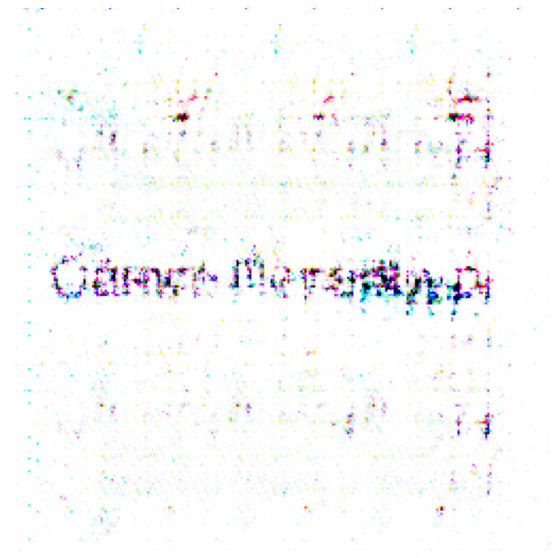

In [ ]:
latent = torch.randn(1, latent_size, 1, 1, device=device)
fake_images = model["generator"](latent)
# preds = model["discriminator"](fake_images)
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
torch.save(model['discriminator'].state_dict(), 'discr_weights_spb_all_500.pth')

In [ ]:
torch.save(model['generator'].state_dict(), 'gen_weights_spb_all_500.pth')

Посмотрим на результаты обучения. Вот так выглядят котики, сгенерированные на последней эпохе обучения:

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
epochs

500

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-{epochs:04d}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

TypeError: ignored

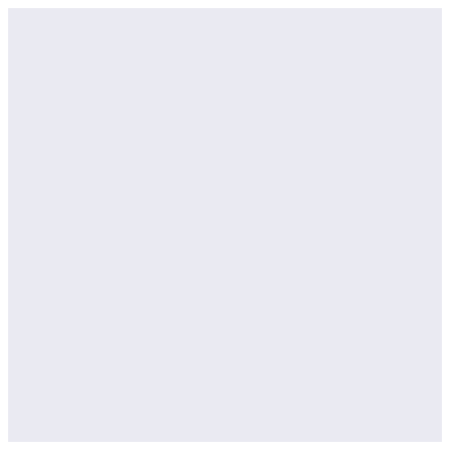

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

TypeError: ignored

TypeError: ignored

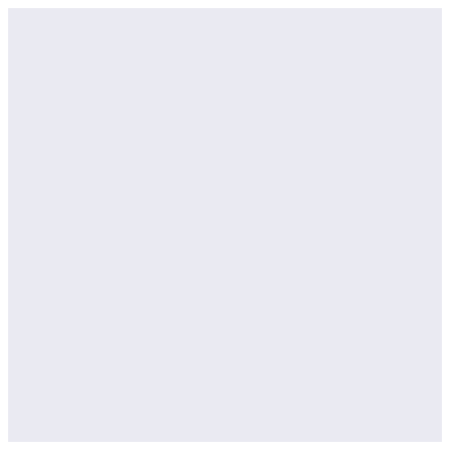

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Как мы видим, изображение в целом получается похожим, однако есть много артефактов

Посмотрим на графики loss генератора и дискриминатора и score дискриминатора

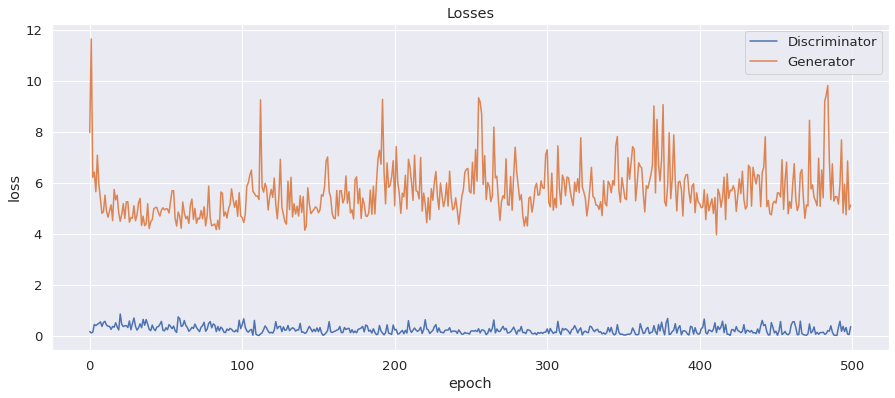

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

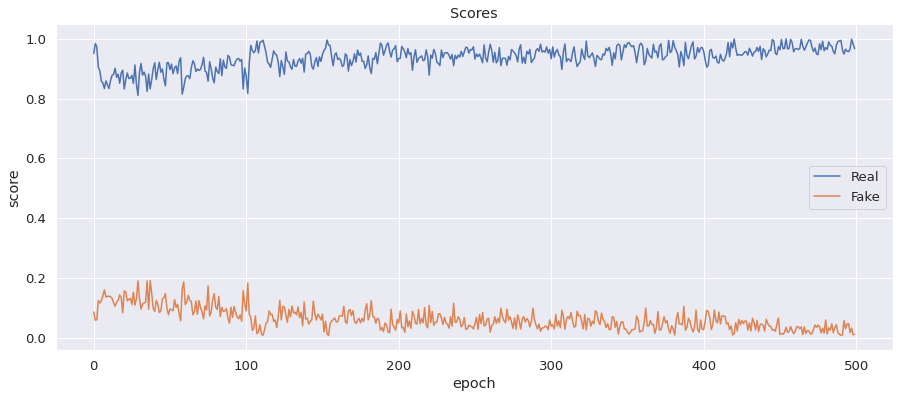

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');